/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_1885/456230787.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sub['frequency'] = sub['count'] / sub['count'].sum()
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_1885/456230787.py:11: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  base = plt.cm.get_cmap(base_cmap, 256)
/var/folders/8h/kqm5zszn2q5bhndj3_skhmgh0000gn/T/ipykernel_1885/456230787.py:44: UserWarning: The following kwargs were not used by contour: 'shading'
  im = ax.contourf(X, Y, Z, cmap=cmap, shading='auto')
/var/folders/8h/kqm5zszn2q5bhnd

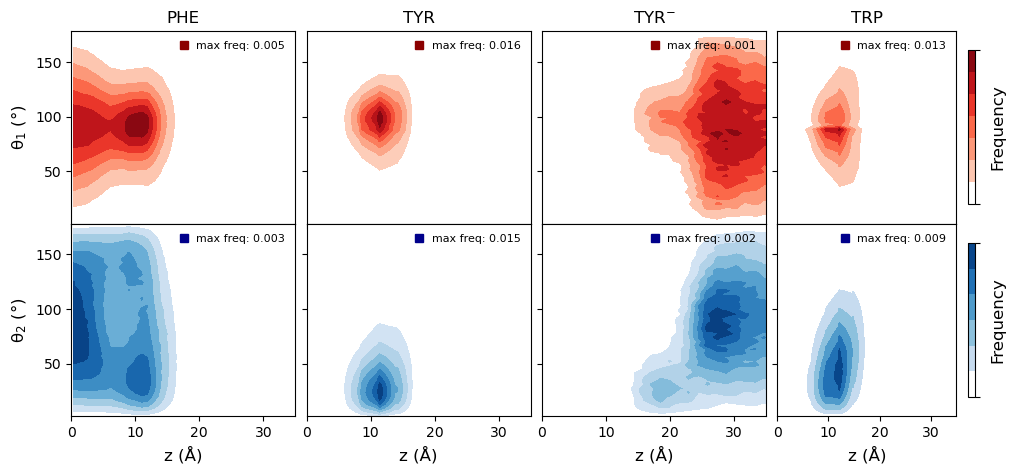

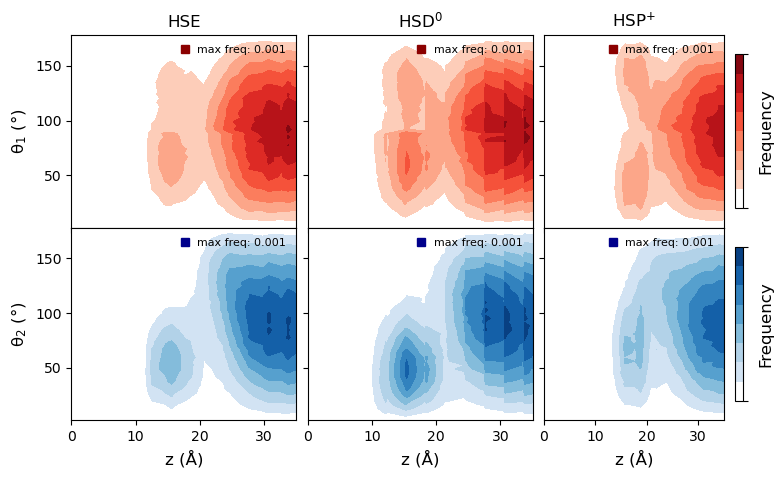

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy.ma as ma
from matplotlib.colors import ListedColormap

input_dir = '../data/aromatics_orientation/'
output_dir = '../plot/aromatics_orientation/'

def custom_colormap(base_cmap='Reds', white_ratio=0.1):
    base = plt.cm.get_cmap(base_cmap, 256)
    colors = base(np.linspace(0, 1, 256))
    n_white = int(256 * white_ratio)
    colors[:n_white] = np.array([1, 1, 1, 1])  # blanc RGBA
    return ListedColormap(colors)

def plot_groups(aas, labels, title='aromatics_angles', mark_max=False, individual_cbar=False):
    n = len(aas)
    fig, axes = plt.subplots(2, n,
                             figsize=(n*3, 2*2.5),
                             sharex=True, sharey=True,
                             gridspec_kw={'wspace':0.05, 'hspace':0})

    for j, aa in enumerate(aas):
        df = pd.read_csv(input_dir+f'freq_angle_{aa}.dat', sep='\t')
        df['z_center'] = df['z_center'].abs()
        df = (df.groupby(['angle_type','z_center','theta_center'], as_index=False)
                ['count'].mean())

        for i, angle in enumerate(['theta1','theta2']):
            ax = axes[i, j]
            sub = df[df['angle_type'] == angle]
            sub['frequency'] = sub['count'] / sub['count'].sum()

            pivot = (sub.pivot(index='theta_center', columns='z_center', values='frequency')
                       .fillna(0)
                       .sort_index().sort_index(axis=1))

            X, Y = np.meshgrid(pivot.columns.values, pivot.index.values)
            #Z = ma.masked_where(pivot.values <= 0.0001, pivot.values)
            Z = pivot.values
            
            cmap = custom_colormap('Reds') if angle == 'theta1' else custom_colormap('Blues')
            im = ax.contourf(X, Y, Z, cmap=cmap, shading='auto')

            ax.set_xlim(0, 35)

            # === 1. AFFICHER FREQUENCE MAXIMALE ===
            freq_max = pivot.values.max()
            color_square = 'darkred' if angle == 'theta1' else 'darkblue'

            ax.plot([], [], color=color_square, marker='s', linestyle='None',
                                            label=f'max freq: {freq_max:.3f}')
            ax.legend(loc='upper right', fontsize=8, frameon=False, handlelength=1.2, handletextpad=0.5)

            # === 2. AJOUTER CROIX ENTRE Z=10 ET 20 ===
            if mark_max:
                sub_z = sub[(sub['z_center'] >= 10) & (sub['z_center'] <= 20)]
                if not sub_z.empty:
                    max_row = sub_z.loc[sub_z['frequency'].idxmax()]
                    ax.plot(max_row['z_center'], max_row['theta_center'],
                            marker='x', markersize=6, color='black', label='max z∈[10,20]')

            if i == 0:
                ax.set_title(labels[aas.index(aa)].upper(), pad=6)
            if j == 0:
                ax.set_ylabel('θ$_1$ (°)' if i==0 else 'θ$_2$ (°)', fontsize=12)
            if i == 1:
                ax.set_xlabel('z (Å)', fontsize=12)
            if individual_cbar:
                cbar = fig.colorbar(im, ax=ax, location='top', orientation='horizontal',
                                    pad=0.01, aspect=20, shrink=0.7)
                ticks = np.linspace(im.get_clim()[0], im.get_clim()[1], 3)
                cbar.set_ticks(ticks)
                cbar.set_ticklabels([f"{t:.3f}" for t in ticks])
                cbar.ax.tick_params(labelsize=8)
            elif j == n-1:
                cbar = fig.colorbar(im, ax=ax, location='right', pad=0.05, shrink=0.8)
                cbar.set_ticks([im.get_clim()[0], im.get_clim()[1]])
                #cbar.set_ticklabels(['low','high'], fontsize=20)
                cbar.set_ticklabels(['',''], fontsize=10)
                cbar.ax.tick_params(labelsize=12)
                cbar.set_label("Frequency", rotation=90, fontsize=12)

    plt.savefig(output_dir+f'{title}.png', dpi=1200, bbox_inches='tight')
    return fig

fig1 = plot_groups(['scf', 'scy','scym', 'scw'],
                   labels=['PHE', 'TYR', 'TYR$^{-}$', 'TRP'],
                   title='aromatics_angles',
                   mark_max=False,
                   individual_cbar=False)
fig2 = plot_groups(['sche','schd','schp'],
                   labels=['HSE', 'HSD$^0$', 'HSP$^{+}$'],
                   title='histidine_angles',
                   mark_max=False)

